In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
from PIL import Image


In [2]:
import matplotlib.pyplot as plt

augmentation = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.1, 0.1),
        scale=(0.85, 1.15),
        shear=15
    ),
    transforms.ColorJitter(brightness=0.5),
])

def show_augmented_images(img_path, augmentation, n=10):
    img = Image.open(img_path)
    
    plt.figure(figsize=(2*n, 4))
    plt.subplot(1, n+1, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    
    for i in range(n):
        aug_img = augmentation(img)
        plt.subplot(1, n+1, i+2)
        plt.imshow(aug_img)
        plt.title(f"Aug {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


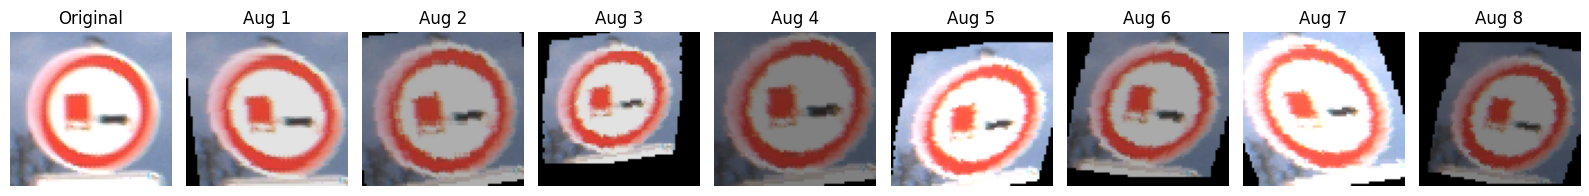

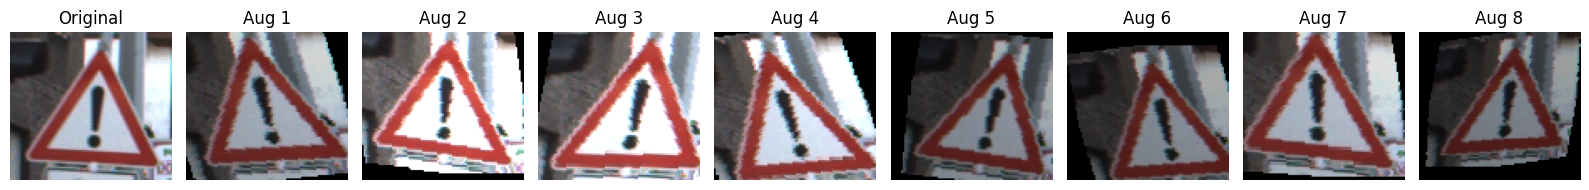

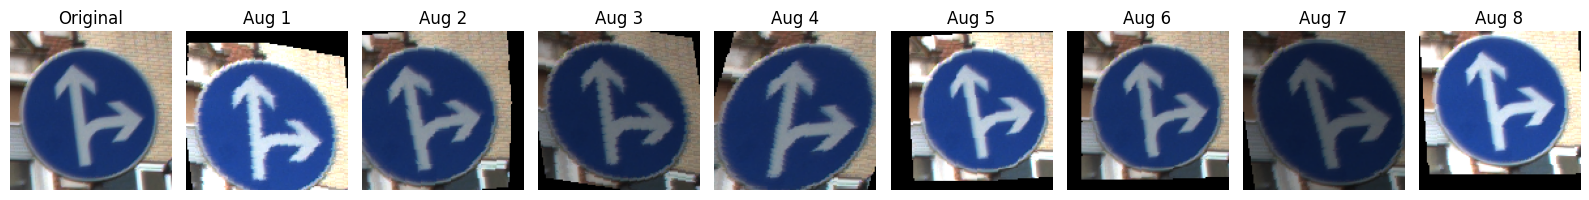

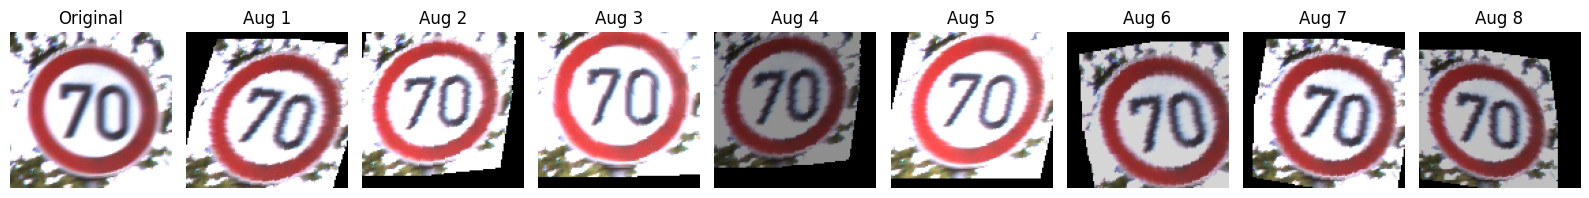

In [3]:
show_augmented_images("Train/10/00010_00057_00024.png", augmentation, 8)
show_augmented_images("Train/18/00018_00005_00012.png", augmentation, 8)
show_augmented_images("Train/36/00036_00008_00029.png", augmentation, 8)
show_augmented_images("Train/4/00004_00012_00029.png", augmentation, 8)

In [4]:
import os
import numpy as np
from PIL import Image

def load_images_from_folder(folder, img_size=(32,32)):
    images = []
    labels = []
    for class_idx in range(43):  
        class_name = str(class_idx)
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            try:
                img = Image.open(fpath).convert('RGB').resize(img_size)
                images.append(np.array(img))
                labels.append(class_idx)
            except Exception as e:
                print(f"Lỗi đọc ảnh {fpath}: {e}")
    X = np.stack(images)      # shape: (N, H, W, C)
    y = np.array(labels)
    return X, y

x_train, y_train = load_images_from_folder('Train')

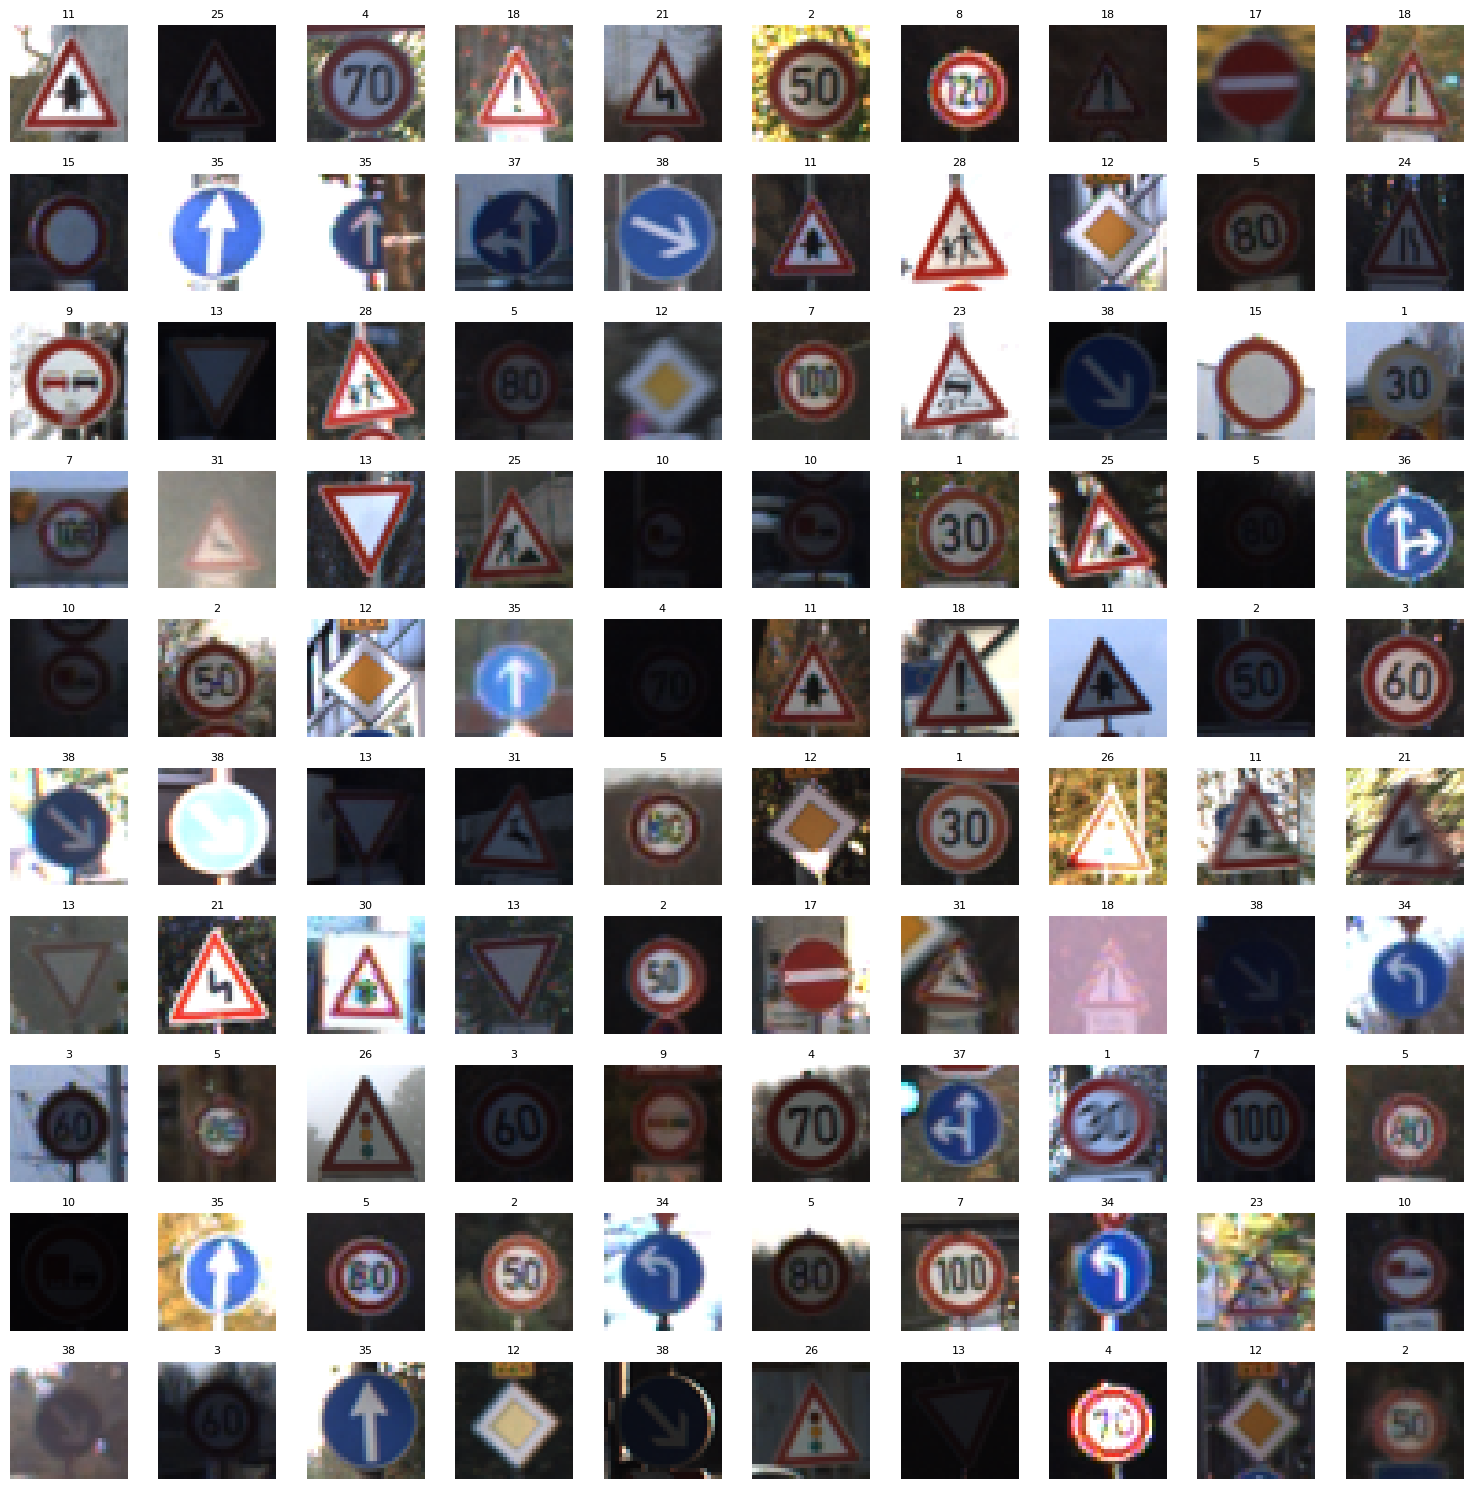

11 25 4 18 21 2 8 18 17 18
15 35 35 37 38 11 28 12 5 24
9 13 28 5 12 7 23 38 15 1
7 31 13 25 10 10 1 25 5 36
10 2 12 35 4 11 18 11 2 3
38 38 13 31 5 12 1 26 11 21
13 21 30 13 2 17 31 18 38 34
3 5 26 3 9 4 37 1 7 5
10 35 5 2 34 5 7 34 23 10
38 3 35 12 38 26 13 4 12 2


In [5]:
import matplotlib.pyplot as plt
idxs = np.random.choice(len(x_train), size=100, replace=False)
x_sample = x_train[idxs]
y_sample = y_train[idxs]

plt.figure(figsize=(15, 15))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_sample[i])
    plt.title(str(y_sample[i]), fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

for i in range(10):
    print(" ".join([str(y_sample[i*10 + j]) for j in range(10)]))

In [6]:
def flip_extend(X, y):
    self_flippable_horizontally = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    self_flippable_vertically = [1, 5, 12, 15, 17]
    self_flippable_both = [32, 40]
    cross_flippable = {
        19: 20, 20: 19,
        33: 34, 34: 33,
        36: 37, 37: 36,
        38: 39, 39: 38,
    }
    num_classes = len(np.unique(y))
    X_extended = []
    y_extended = []
    for c in range(num_classes):
        idx = np.where(y == c)[0]
        X_c = X[idx]
        X_extended.append(X_c)
        y_extended.append(np.full(X_c.shape[0], c))
        # Horizontal flip (giữ nguyên class)
        if c in self_flippable_horizontally:
            X_flipped = X_c[:, :, ::-1, :]
            X_extended.append(X_flipped)
            y_extended.append(np.full(X_flipped.shape[0], c))
        # Horizontal flip (class khác)
        if c in cross_flippable:
            other = cross_flippable[c]
            idx_other = np.where(y == other)[0]
            X_other = X[idx_other]
            X_flipped = X_other[:, :, ::-1, :]
            X_extended.append(X_flipped)
            y_extended.append(np.full(X_flipped.shape[0], c))
        # Vertical flip
        if c in self_flippable_vertically:
            X_flipped = X_c[:, ::-1, :, :]
            X_extended.append(X_flipped)
            y_extended.append(np.full(X_flipped.shape[0], c))
        # Both flip
        if c in self_flippable_both:
            X_flipped = X_c[:, ::-1, ::-1, :]
            X_extended.append(X_flipped)
            y_extended.append(np.full(X_flipped.shape[0], c))
    X_final = np.concatenate(X_extended, axis=0)
    y_final = np.concatenate(y_extended, axis=0)
    return X_final, y_final


In [7]:
from tqdm import tqdm

def augment_images(X, y, augmentation, target_count=10000, out_size=(32,32)):
    X_aug = []
    y_aug = []
    unique, counts = np.unique(y, return_counts=True)
    n_aug_arr = {label: int(target_count // count - 1) for label, count in zip(unique, counts)}
    for img_np, label in tqdm(zip(X, y), total=len(X), desc="Augmenting"):
        img = Image.fromarray(img_np)
        img_resized = img.resize(out_size, resample=Image.Resampling.BILINEAR)
        X_aug.append(np.array(img_resized))
        y_aug.append(label)
        n_aug = n_aug_arr[label]
        for _ in range(n_aug):
            img_aug = augmentation(img)
            img_aug_resized = img_aug.resize(out_size, resample=Image.Resampling.BILINEAR)
            X_aug.append(np.array(img_aug_resized))
            y_aug.append(label)
    unique, counts = np.unique(y_aug, return_counts=True)
    add = [0] * 43  # 43 class
    for label, count in zip(unique, counts):
        add[label] = target_count - count
    for img_np, label in tqdm(zip(X, y), total=len(X), desc="AugmentingP2"):
        img = Image.fromarray(img_np)
        img_resized = img.resize(out_size, resample=Image.Resampling.BILINEAR)
        if add[label] > 0:
            img_aug = augmentation(img)
            img_aug_resized = img_aug.resize(out_size, resample=Image.Resampling.BILINEAR)
            X_aug.append(np.array(img_aug_resized))
            y_aug.append(label)
            add[label] -= 1
    return np.stack(X_aug), np.array(y_aug)

x_train_aug, y_train_aug = flip_extend(x_train, y_train)
x_train_final, y_train_final = augment_images(x_train_aug, y_train_aug, augmentation)
print(x_train_final.shape[0])

AugmentingP2: 100%|██████████| 63538/63538 [00:05<00:00, 12404.60it/s]


430000


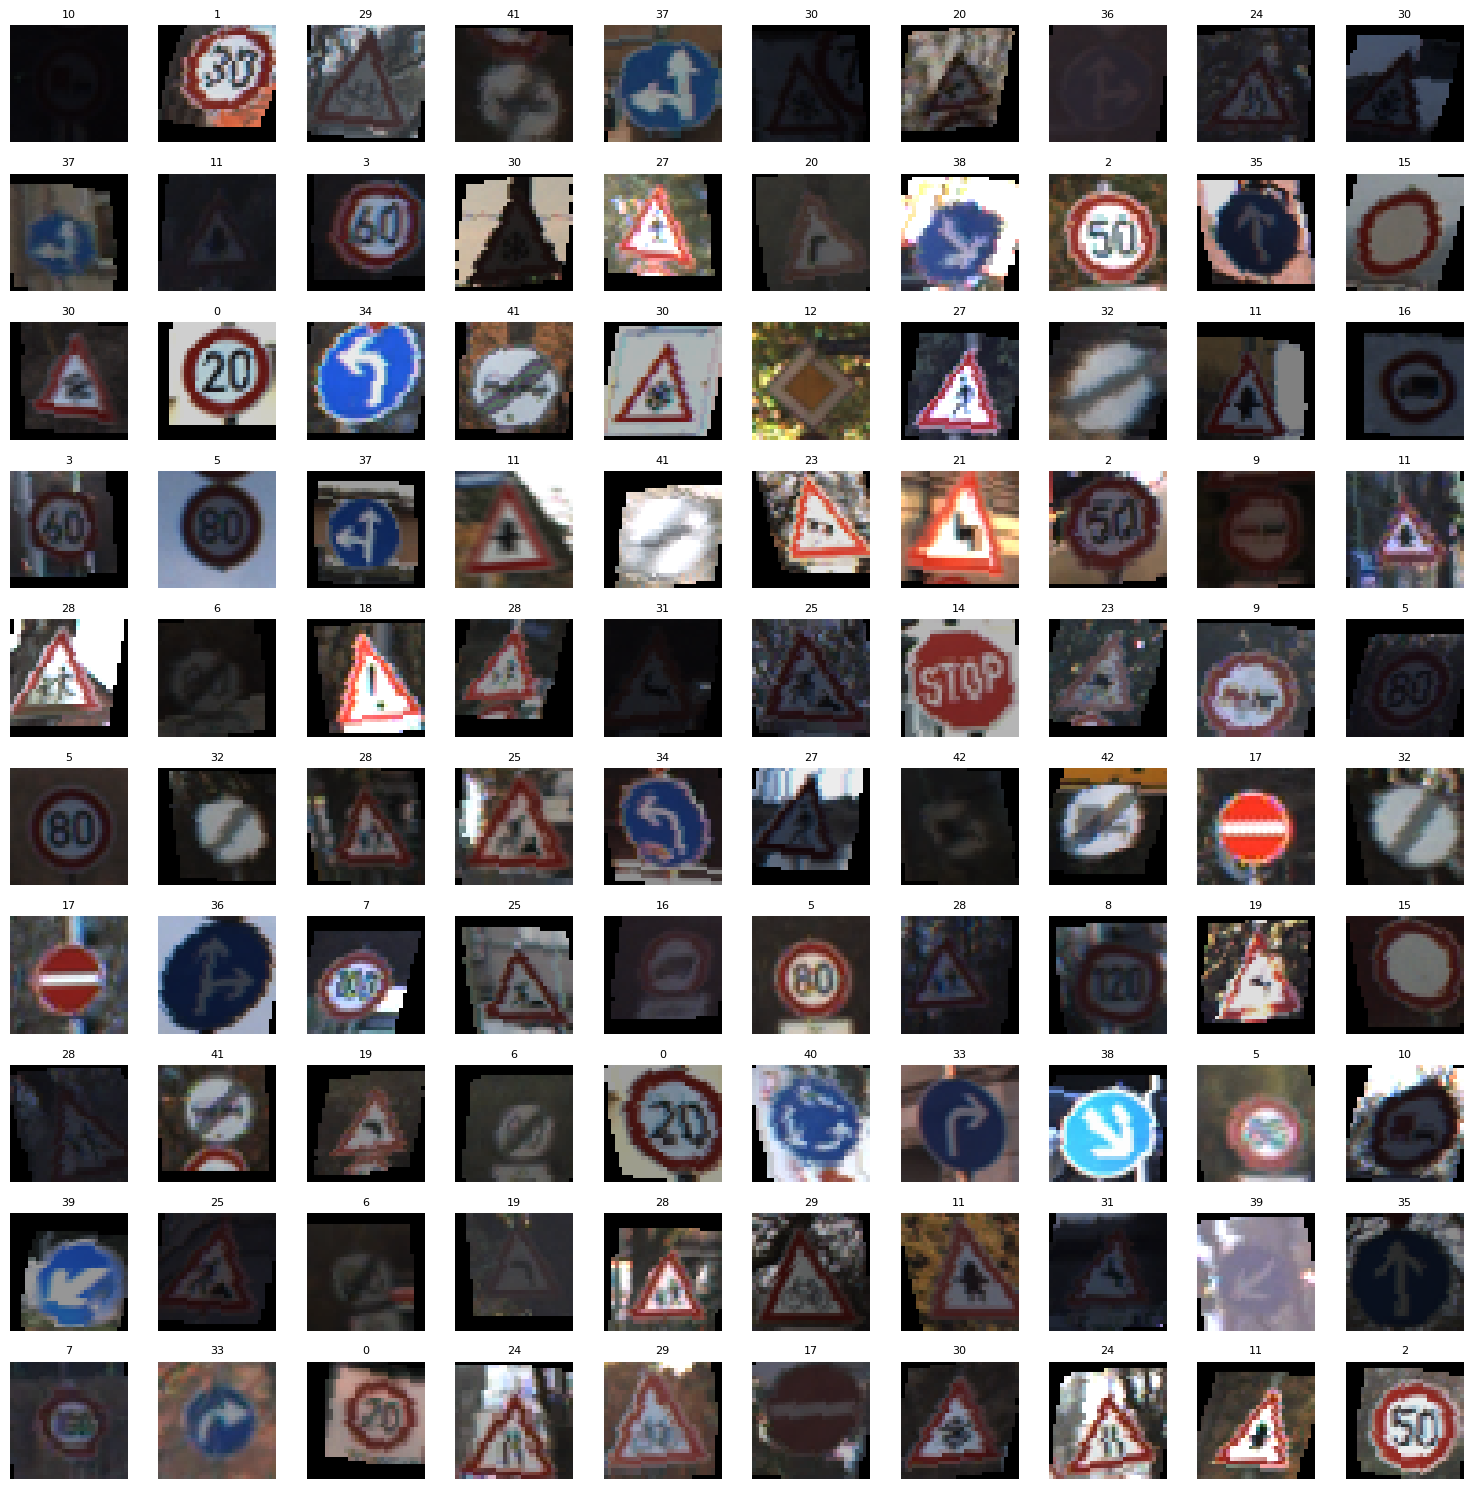

10 1 29 41 37 30 20 36 24 30
37 11 3 30 27 20 38 2 35 15
30 0 34 41 30 12 27 32 11 16
3 5 37 11 41 23 21 2 9 11
28 6 18 28 31 25 14 23 9 5
5 32 28 25 34 27 42 42 17 32
17 36 7 25 16 5 28 8 19 15
28 41 19 6 0 40 33 38 5 10
39 25 6 19 28 29 11 31 39 35
7 33 0 24 29 17 30 24 11 2


In [8]:
import matplotlib.pyplot as plt
idxs = np.random.choice(len(x_train_final), size=100, replace=False)
x_sample = x_train_final[idxs]
y_sample = y_train_final[idxs]

plt.figure(figsize=(15, 15))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_sample[i])
    plt.title(str(y_sample[i]), fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

for i in range(10):
    print(" ".join([str(y_sample[i*10 + j]) for j in range(10)]))

In [9]:
import gc
from sklearn.model_selection import train_test_split

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_final, y_train_final, test_size=0.2, random_state=42, stratify=y_train_final
)
del x_train_final, y_train_final, x_train_aug, y_train_aug, x_train, y_train
gc.collect()
print("Train:", x_train_split.shape[0])
print("Val:", x_val_split.shape[0])

Train: 344000
Val: 86000


In [8]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)      # Input 3 kênh (RGB)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        # FC
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [11]:
num_classes = 43  
model = TrafficSignCNN(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        # X: (N, H, W, C), y: (N,)
        self.X = torch.from_numpy(X).permute(0, 3, 1, 2).float() / 255.   # (N, 3, H, W), normalize 0-1
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_dataset = NumpyDataset(x_train_split, y_train_split)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataset = NumpyDataset(x_val_split, y_val_split)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    loss = running_loss / total
    acc = 100. * correct / total
    return loss, acc

In [ ]:
hist = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

def train_model(model, train_loader, val_loader, optimizer, criterion, device,
                epochs=10, patience=5):
    model = model.to(device)
    best_val_loss = float('inf')
    wait = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, dim=1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)

        val_loss = val_running_loss / val_total
        val_acc = 100.0 * val_correct / val_total

        # === Lưu lịch sử ===
        hist['train_loss'].append(train_loss)
        hist['train_acc'].append(train_acc)
        hist['val_loss'].append(val_loss)
        hist['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Early Stopping 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            best_state = model.state_dict()  # lưu checkpoint tốt nhất
        else:
            wait += 1
            if wait >= patience:
                print(f"No improvement in val_loss for {patience} epochs. Stopping early at epoch {epoch+1}.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    print("Training finished. Best val_loss: {:.4f}".format(best_val_loss))
    return model, hist


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, history = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=30, patience=7)

Epoch 1/30 | Train Loss: 1.1324 | Train Acc: 62.63% | Val Loss: 0.1236 | Val Acc: 96.79%
Epoch 2/30 | Train Loss: 0.4245 | Train Acc: 85.46% | Val Loss: 0.0750 | Val Acc: 97.97%
Epoch 3/30 | Train Loss: 0.2401 | Train Acc: 92.10% | Val Loss: 0.0351 | Val Acc: 99.13%
Epoch 4/30 | Train Loss: 0.1419 | Train Acc: 95.54% | Val Loss: 0.0237 | Val Acc: 99.33%
Epoch 5/30 | Train Loss: 0.0963 | Train Acc: 97.05% | Val Loss: 0.0210 | Val Acc: 99.37%
Epoch 6/30 | Train Loss: 0.0744 | Train Acc: 97.76% | Val Loss: 0.0146 | Val Acc: 99.57%
Epoch 7/30 | Train Loss: 0.0595 | Train Acc: 98.21% | Val Loss: 0.0233 | Val Acc: 99.30%
Epoch 8/30 | Train Loss: 0.0521 | Train Acc: 98.45% | Val Loss: 0.0123 | Val Acc: 99.62%
Epoch 9/30 | Train Loss: 0.0448 | Train Acc: 98.69% | Val Loss: 0.0135 | Val Acc: 99.57%
Epoch 10/30 | Train Loss: 0.0395 | Train Acc: 98.83% | Val Loss: 0.0114 | Val Acc: 99.64%
Epoch 11/30 | Train Loss: 0.0359 | Train Acc: 98.92% | Val Loss: 0.0111 | Val Acc: 99.64%
Epoch 12/30 | Train

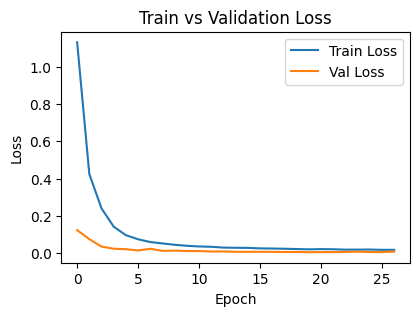

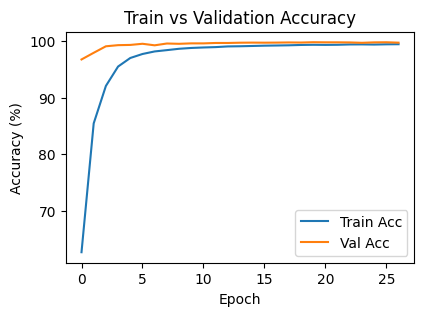

In [35]:
import matplotlib.pyplot as plt

# Giả sử đã gọi:
# model, history = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=50, patience=7)

# 1. Vẽ Loss
plt.figure(figsize=(4.5, 3))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

# 2. Vẽ Accuracy
plt.figure(figsize=(4.5, 3))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train vs Validation Accuracy')
plt.show()


In [18]:
torch.save(model.state_dict(), "traffic_sign_cnn.pth")

In [2]:
def predict_image(model, image_path, device='cuda', class_names=None):
    model.eval()
    img = Image.open(image_path).convert('RGB').resize((32, 32))
    img_np = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        pred_label = predicted.item()
    if class_names:
        return class_names[pred_label]
    return pred_label

In [33]:
import pandas as pd

df = pd.read_csv("Test.csv")
correct = 0

for idx, row in df.iterrows():
    img_path = row['Path']
    true_label = row['ClassId']
    pred_label = predict_image(model, img_path, device)
    if pred_label == true_label:
        correct += 1

total = len(df)
accuracy = correct / total * 100
print(f"Số ảnh dự đoán đúng trên tập test: {correct} / {total} ({accuracy:.2f}%)")

Số ảnh dự đoán đúng trên tập test: 12558 / 12630 (99.43%)


In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficSignCNN(num_classes=43)
model.load_state_dict(torch.load("traffic_sign_cnn.pth", map_location=device))
model = model.to(device)
model.eval()

TrafficSignCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=Tr

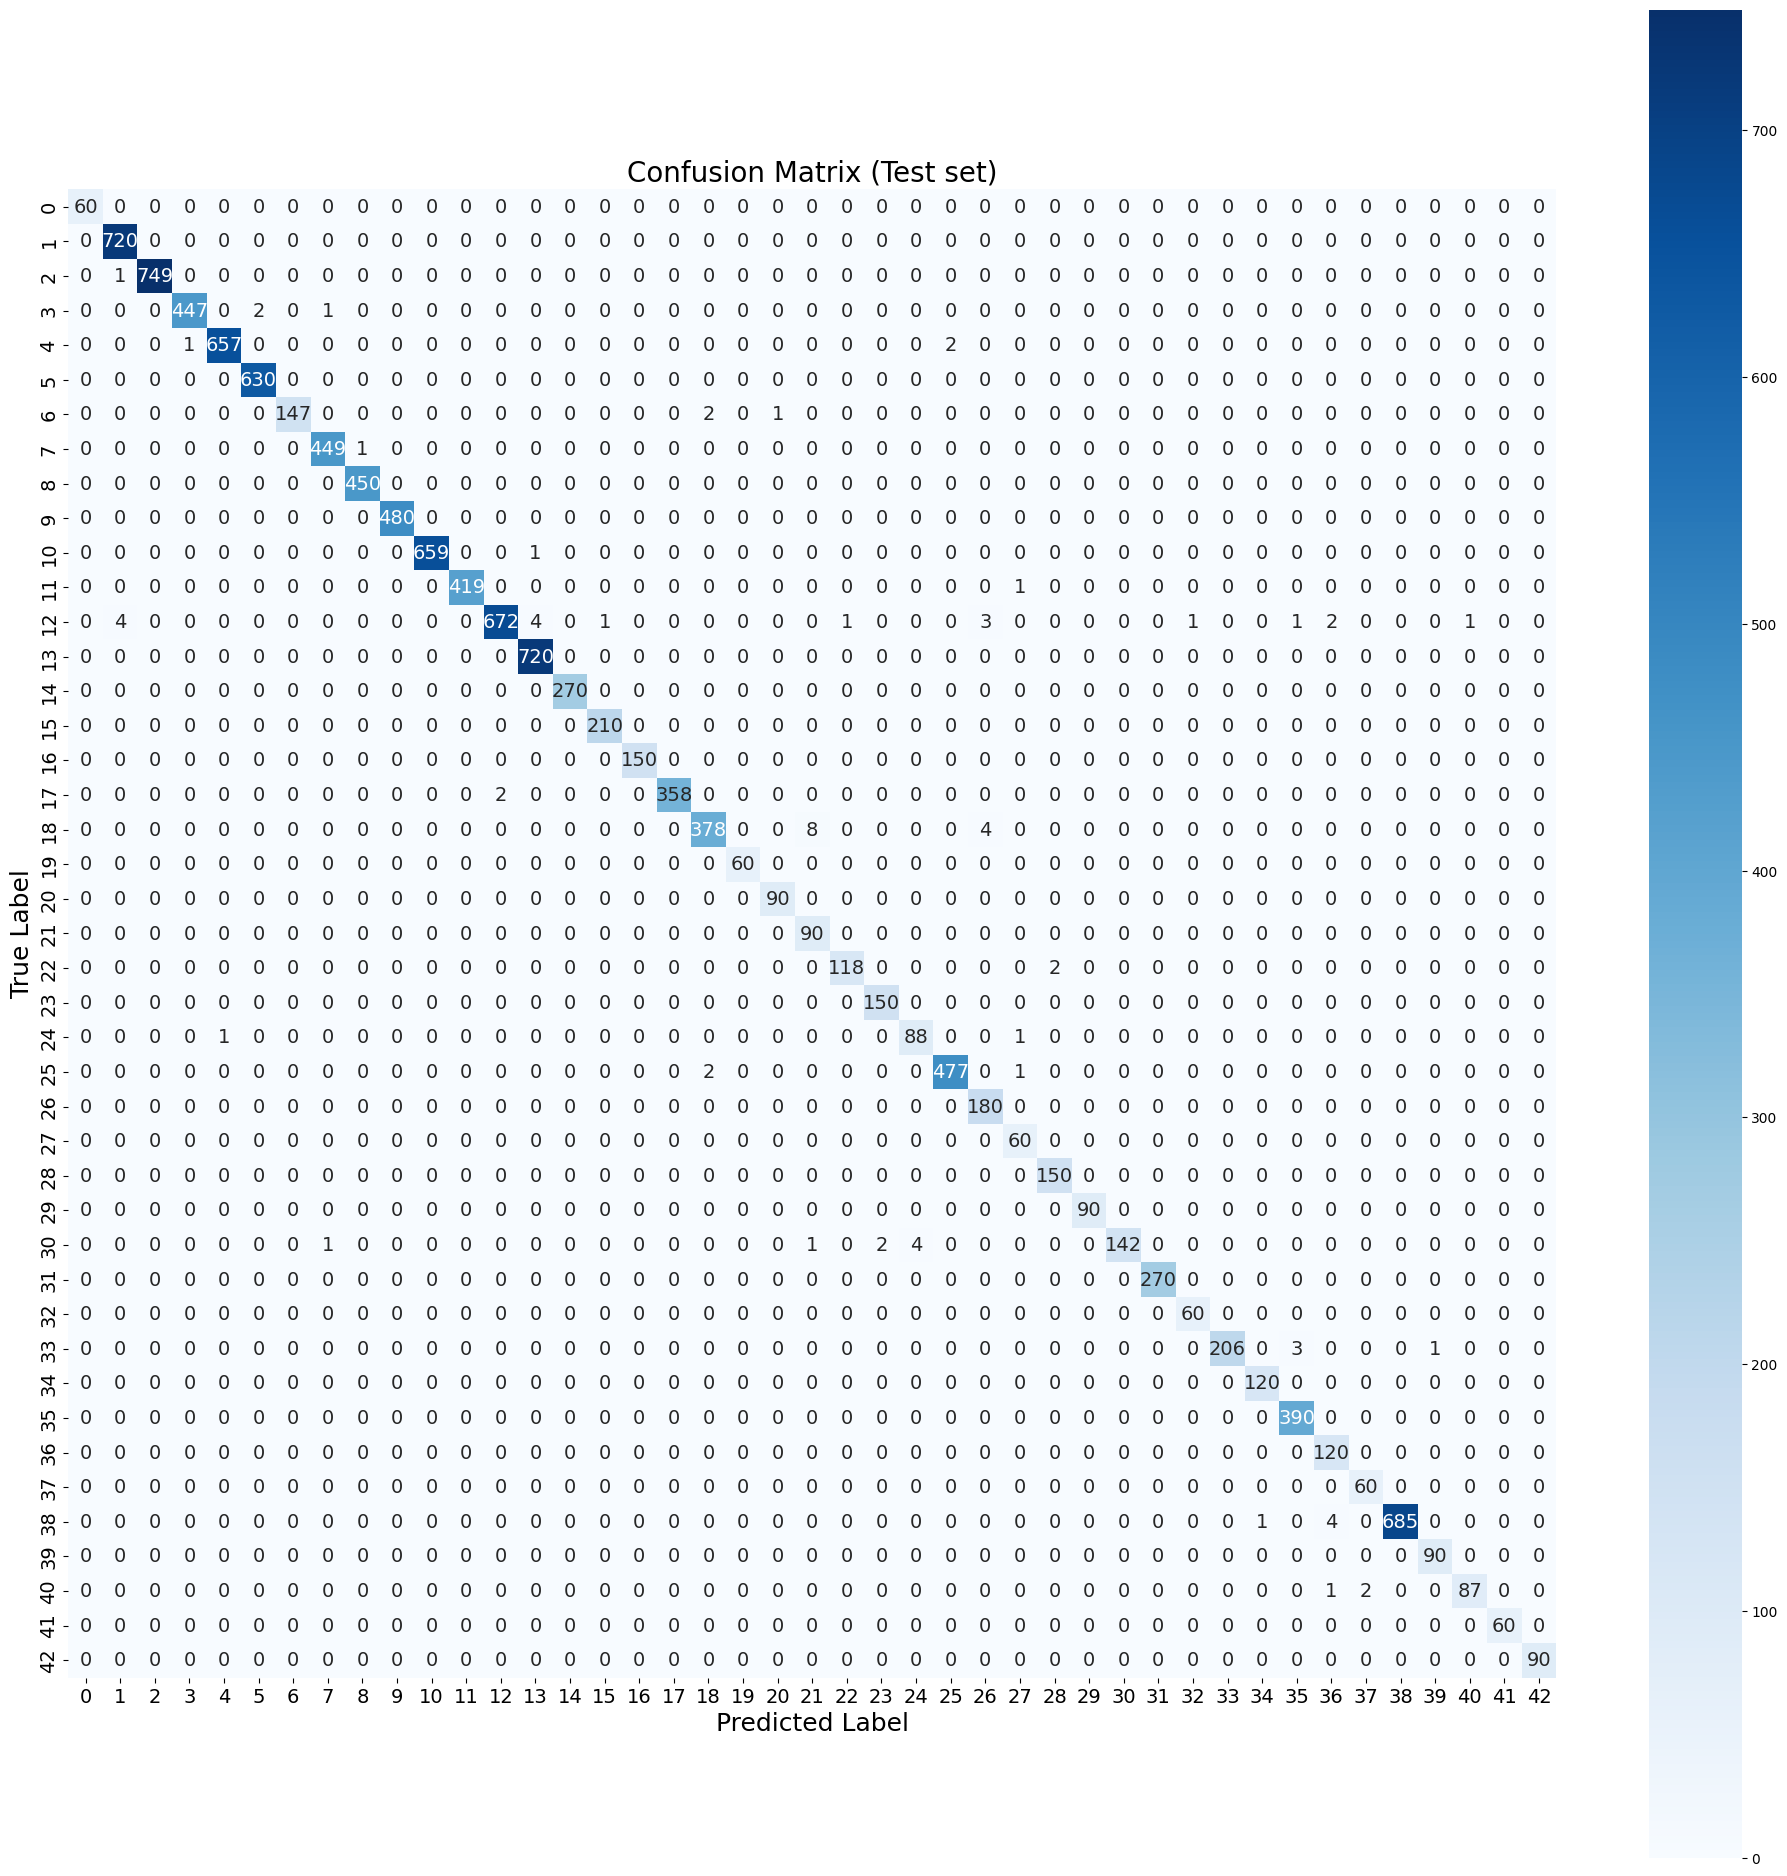

In [11]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Test.csv")
y_true = []
y_pred = []

for idx, row in df.iterrows():
    img_path = row['Path']
    true_label = row['ClassId']
    pred_label = predict_image(model, img_path)
    y_true.append(true_label)
    y_pred.append(pred_label)

class_names = [str(i) for i in range(43)]

# 1. Classification report
report_str = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, output_dict=False)
with open("classification_report_val.txt", "w", encoding="utf-8") as f:
    f.write(report_str)
    
# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(43)))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(24, 24))
sns.heatmap(
    df_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    square=True,
    annot_kws={"size": 14}
)
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Confusion Matrix (Test set)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()